In [1]:
from numpy import *
import numpy as np
import pandas as pd
from math import log
import operator

In [2]:
df = pd.read_csv("watermelon.csv")
data = df.values[:,1:].tolist()
data_full = data[:]
labels = df.columns.values[1:-1].tolist()
labels_full = labels[:]
df.head()

,Idx,color,root,knocks,texture,navel,touch,density,sugar_ratio,label
0,1,dark_green,curl_up,little_heavily,distinct,sinking,hard_smooth,0.697,0.460,1
1,2,black,curl_up,heavily,distinct,sinking,hard_smooth,0.774,0.376,1
2,3,black,curl_up,little_heavily,distinct,sinking,hard_smooth,0.634,0.264,1
3,4,dark_green,curl_up,heavily,distinct,sinking,hard_smooth,0.608,0.318,1
4,5,light_white,curl_up,little_heavily,distinct,sinking,hard_smooth,0.556,0.215,1


In [3]:
# calculate the shannon information
def calshannonEnt(dataset):
    numEntries = len(dataset)
    labelcount = {}
    # create a diction for every posiible labels
    for featVec in dataset:
        currentLabel = featVec[-1]
        if currentLabel not in labelcount.keys():
            labelcount[currentLabel] = 0
        labelcount[currentLabel]+=1
    shannonEnt = 0.0
    for key in labelcount:
        prob = float(labelcount[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [4]:
def splitdataset(dataset, axis, value):
    retdataset = []
    for featVec in dataset:
        if featVec[axis] == value:
            reducedfeatvec = featVec[:axis]
            reducedfeatvec.extend(featVec[axis+1:])
            retdataset.append(reducedfeatvec)
    return retdataset

In [5]:
def splitContinuousDataSet(dataset,axis,value,direction):
    retDataSet=[]
    for featVec in dataset:
        if direction==0:
            if featVec[axis]>value:
                reducedFeatVec=featVec[:axis]
                reducedFeatVec.extend(featVec[axis+1:])
                retDataSet.append(reducedFeatVec)
        else:
            if featVec[axis]<=value:
                reducedFeatVec=featVec[:axis]
                reducedFeatVec.extend(featVec[axis+1:])
                retDataSet.append(reducedFeatVec)
    return retDataSet

In [6]:
#选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataset,labels):
    numFeatures=len(dataset[0])-1
    baseEntropy=calshannonEnt(dataset)
    bestInfoGain=0.0
    bestFeature=-1
    bestSplitDict={}
    for i in range(numFeatures):
        featList=[example[i] for example in dataset]
        #对连续型特征进行处理
        if type(featList[0]).__name__=='float' or type(featList[0]).__name__=='int':
            #产生n-1个候选划分点
            sortfeatList=sorted(featList)
            splitList=[]
            for j in range(len(sortfeatList)-1):
                splitList.append((sortfeatList[j]+sortfeatList[j+1])/2.0)
            
            bestSplitEntropy=10000
            slen=len(splitList)
            #求用第j个候选划分点划分时，得到的信息熵，并记录最佳划分点
            for j in range(slen):
                value=splitList[j]
                newEntropy=0.0
                subDataSet0=splitContinuousDataSet(dataset,i,value,0)
                subDataSet1=splitContinuousDataSet(dataset,i,value,1)
                prob0=len(subDataSet0)/float(len(dataset))
                newEntropy+=prob0*calshannonEnt(subDataSet0)
                prob1=len(subDataSet1)/float(len(dataset))
                newEntropy+=prob1*calshannonEnt(subDataSet1)
                if newEntropy<bestSplitEntropy:
                    bestSplitEntropy=newEntropy
                    bestSplit=j
            #用字典记录当前特征的最佳划分点
            bestSplitDict[labels[i]]=splitList[bestSplit]
            infoGain=baseEntropy-bestSplitEntropy
        #对离散型特征进行处理
        else:
            uniqueVals=set(featList)
            newEntropy=0.0
            #计算该特征下每种划分的信息熵
            for value in uniqueVals:
                subDataSet=splitdataset(dataset,i,value)
                prob=len(subDataSet)/float(len(dataset))
                newEntropy+=prob*calshannonEnt(subDataSet)
            infoGain=baseEntropy-newEntropy
        if infoGain>bestInfoGain:
            bestInfoGain=infoGain
            bestFeature=i
    #若当前节点的最佳划分特征为连续特征，则将其以之前记录的划分点为界进行二值化处理
    #即是否小于等于bestSplitValue
    if type(dataset[0][bestFeature]).__name__=='float' or type(dataset[0][bestFeature]).__name__=='int':      
        bestSplitValue=bestSplitDict[labels[bestFeature]]        
        labels[bestFeature]=labels[bestFeature]+'<='+str(bestSplitValue)
        for i in range(shape(dataset)[0]):
            if dataset[i][bestFeature]<=bestSplitValue:
                dataset[i][bestFeature]=1
            else:
                dataset[i][bestFeature]=0
    return bestFeature

In [7]:
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
    return max(classCount)
 

In [8]:
#主程序，递归产生决策树
def createTree(dataSet,labels,data_full,labels_full):
    classList=[example[-1] for example in dataSet]
    if classList.count(classList[0])==len(classList):
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeat=chooseBestFeatureToSplit(dataSet,labels)
    bestFeatLabel=labels[bestFeat]
    myTree={bestFeatLabel:{}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    if type(dataSet[0][bestFeat]).__name__=='str':
        currentlabel=labels_full.index(labels[bestFeat])
        featValuesFull=[example[currentlabel] for example in data_full]
        uniqueValsFull=set(featValuesFull)
    del(labels[bestFeat])
    #针对bestFeat的每个取值，划分出一个子树。
    for value in uniqueVals:
        subLabels=labels[:]
        if type(dataSet[0][bestFeat]).__name__=='str':
            uniqueValsFull.remove(value)
        myTree[bestFeatLabel][value]=createTree(splitdataset(dataSet,bestFeat,value),subLabels,data_full,labels_full)
    if type(dataSet[0][bestFeat]).__name__=='str':
        for value in uniqueValsFull:
            myTree[bestFeatLabel][value]=majorityCnt(classList)
    return myTree

In [9]:
df = pd.read_csv("watermelon.csv")
data = df.values[:,1:].tolist()
data_full = data[:]
labels = df.columns.values[1:-1].tolist()
labels_full = labels[:]
myTree = createTree(data, labels, data_full, labels_full)
myTree

{'texture': {'distinct': {'density<=0.3815': {0: 1, 1: 0}},
  'blur': 0,
  'little_blur': {'touch': {'hard_smooth': 0, 'soft_stick': 1}}}}

In [10]:
import matplotlib.pyplot as plt
decisionNode=dict(boxstyle="sawtooth",fc="0.8")
leafNode=dict(boxstyle="round4",fc="0.8")
arrow_args=dict(arrowstyle="<-")

In [11]:
#计算树的叶子节点数量
def getNumLeafs(myTree):
    numLeafs=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else: numLeafs+=1
    return numLeafs
 
#计算树的最大深度
def getTreeDepth(myTree):
    maxDepth=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth=1+getTreeDepth(secondDict[key])
        else: thisDepth=1
        if thisDepth>maxDepth:
            maxDepth=thisDepth
    return maxDepth

In [12]:
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',\
    xytext=centerPt,textcoords='axes fraction',va="center", ha="center",\
    bbox=nodeType,arrowprops=arrow_args)

def plotMidText(cntrPt,parentPt,txtString):
    lens=len(txtString)
    xMid=(parentPt[0]+cntrPt[0])/2.0-lens*0.002
    yMid=(parentPt[1]+cntrPt[1])/2.0
    createPlot.ax1.text(xMid,yMid,txtString)

In [13]:
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs=getNumLeafs(myTree)
    depth=getTreeDepth(myTree)
    firstStr=list(myTree.keys())[0]
    cntrPt=(plotTree.x0ff+(1.0+float(numLeafs))/2.0/plotTree.totalW,plotTree.y0ff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict=myTree[firstStr]
    plotTree.y0ff=plotTree.y0ff-1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.x0ff=plotTree.x0ff+1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.x0ff,plotTree.y0ff),cntrPt,leafNode)
            plotMidText((plotTree.x0ff,plotTree.y0ff),cntrPt,str(key))
    plotTree.y0ff=plotTree.y0ff+1.0/plotTree.totalD

In [14]:
def createPlot(inTree):
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW=float(getNumLeafs(inTree))
    plotTree.totalD=float(getTreeDepth(inTree))
    plotTree.x0ff=-0.5/plotTree.totalW
    plotTree.y0ff=1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

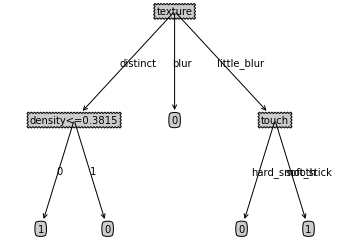

In [15]:
createPlot(myTree)